In [142]:
using MiniOps
using LinearAlgebra
using Plots, FFTW

In [48]:
function test_conv()

    h = randn(15)
    A = conv1d_op(h)

    x1 = randn(120) 
    y1 = A*x1
    
    y2 = randn(size(y1))
    x2 = A'*y2

println("<y1, y2> - <x1, x2>: ", y1'*y2 -x2'*x1)
println(A.name, " size : ", A.m, A.n)

end

test_conv()

<y1, y2> - <x1, x2>: -9.992007221626409e-15
conv1d size : -1-1


In [49]:

function test_composition()

  println("Testing do-product for A = S1*R*S2")
  println("S1 is scaling")
  println("S2 applies diag weights")
  println("R is sampling")

    nx, ny = 20, 30
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.7
    idx  = findall(mask)
    R = sampling_op(idx, full_size)

    S1 = scaling_op(3.0)
    S2 = diag_op(ones(nx,ny))

    A = S1*R*S2
    
    x1 = randn(nx, ny)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y2,y1))
println("name = ", A.name, " Size: ",  A.m, A.n)
end
    
test_composition()

Testing do-product for A = S1*R*S2
S1 is scaling
S2 applies diag weights
R is sampling
<x1,x2> = -33.35553285503011
<y1,y2> = -33.355532855030134
name = scaling*sampling*diag Size: -1-1


In [50]:
  # Multiple dispatch is used to generate two operators 

  A = fft_op(randn(ComplexF64,20,20))
  B = fft_op()

x1 = randn(ComplexF64,20,20)
y1 = A*x1

y2 = randn(ComplexF64,20,20)
x2 = A'*y2

println("<x1,x2> = ", round(dot(x1,x2), digits=8))
println("<y1,y2> = ", round(dot(y1,y2), digits=8))



A = with_shape(A, x1)
println(A.name,   "m :",  A.m, " n : ", A.n)
println(B.name,   "m :",  B.m, " n : ", B.n)

B = with_shape(B, x1)
println(B.name,   "m :",  B.m, " n : ", B.n)

<x1,x2> = 30.38227961 + 9.86250513im
<y1,y2> = 30.38227961 + 9.86250513im
fft_plannedm :400 n : 400
fft_opm :-1 n : -1
fft_opm :400 n : 400


In [51]:
function test_conv_multichannel()

    wavelet = rand(10)
    A = conv1d_cols_op(wavelet)

    x1 = randn(200,100)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y1,y2))
    
println(A.name," m : ", A.m, " n : ", A.n)

end
test_conv_multichannel()

<x1,x2> = -424.8870470803065
<y1,y2> = -424.8870470803068
conv1d_cols m : -1 n : -1


In [176]:
# demo Fourier reconstruction with SD 
# c= F'PR'y y = R P' Fc

nx,  ny  = 100, 100
nkx, nky = 256, 256
p1,  p2  = (nkx-nx)÷2,(nky-ny)÷2

full_size = (nx, ny)
mask = rand(nx * ny) .> 0.95
idx  = findall(mask)
    
R = sampling_op(idx, full_size) 

x = zeros(ComplexF64, nkx, nky)
F = fft_op(x)


x[4,5] = 3.0 - im*3.0; x[2,6]   = 2.0 - im*3.0; x[2, 251] = 2.0 - im*3.0
x[5,251] = 1.2 - im*3.0 ;x[253,2] = 1.0 - im*3.0; x[251,252] = 2.0 - im*2.0

P = pad_op((nx,ny),(p1,p2),(p1,p2))
A = R*P'*F
y = A*x

u0 = randn(ComplexF64,nkx,nky)
e = opnorm_power(A,u0)

μ = 0.02
ν = 0.98/e^2
u = ista(A, y, u0, μ, ν; niter=900, verbose=false);



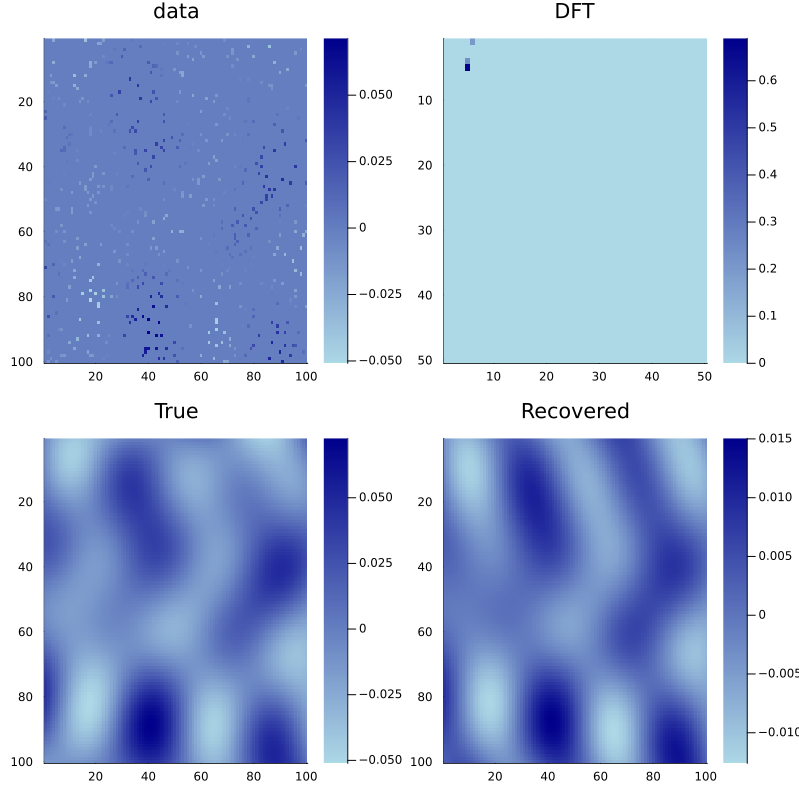

In [177]:

p1 = heatmap(real.(R'*y), cmap=:blues, yflip=true, title="data")
p2 = heatmap(((abs.(u))[1:50,1:50]),  cmap=:blues, yflip=true, title="DFT")
p3 = heatmap(real.(P'*F*x), cmap=:blues, yflip=true, title="True")
p4 = heatmap(real.(P'*F*u),  cmap=:blues, yflip=true, title="Recovered")
plot(p1, p2, p3, p4, layout = (2,2), size=(800,800))

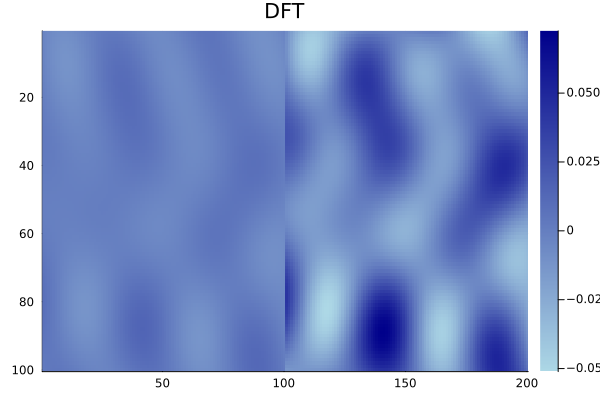

In [178]:
heatmap(hcat(real.(P'*F*u),real.(P'*F*x)),  cmap=:blues, yflip=true, title="DFT")

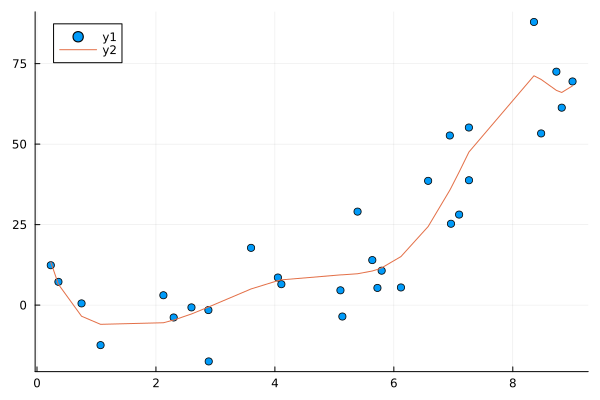

In [175]:

"""
    poly_fit_matrix(x, P)

Return the design (Vandermonde) matrix for polynomial fitting of degree `P`.

Given x[1:n], it returns an n × (P+1) matrix A with

    A[i, j+1] = x[i]^j,      j = 0,...,P

So the columns are: [1, x, x.^2, ..., x.^P].
"""
function poly_fit_matrix(x::AbstractVector, P::Integer)
    n = length(x)
    T = eltype(x)
    A = Matrix{T}(undef, n, P+1)

    @inbounds for i in 1:n
        v = one(T)        # x[i]^0
        A[i, 1] = v
        for j in 2:P+1
            v *= x[i]     # multiply by x[i] each time
            A[i, j] = v   # now v = x[i]^(j-1)
        end
    end

    return A
end

x = sort(rand(30)*10)
P = 10
A =  poly_fit_matrix(x, P)
y = cos.(2*pi*x*2.8)+0.1*x.^3+10*randn(30)
scatter(x,y)

c = (A'*A)\(A'*y)
yp = A*c
plot!(x,yp)


In [168]:
c

21-element Vector{Float64}:
   79.79903161247107
 -300.0544193588039
  437.09436790565405
 -328.17407041082816
  139.59860136523187
  -32.18791646141829
    2.6536653631864424
    0.48469108061471244
   -0.13667561520775307
    0.008410326208164768
    ⋮
   -1.866151322339664e-5
    1.2013547122383048e-6
    2.9454581546609442e-8
    4.915988558935258e-9
   -5.728783223735527e-10
   -1.895497679686269e-10
    3.085414561336346e-11
   -1.6906559544698234e-12
    3.293470140156976e-14